In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import matthews_corrcoef
from sklearn.model_selection import KFold

## Summary of Results:

$\hat Q$ is the outcome estimator, $\hat G$ is the propensity score estimator. Their respective columns tell us which estimators are use e.g. NN means a neural network was used.

'Reduction' is the relative percent error reduction when compared against the plug-in estimator using the outcome model alone. The results are averages over 60 simulations.


| Method | $\hat Q$ | $\hat G$ | Reduction $\%$ | Rel. Error $\%$ |
| --- | --- | --- | --- |--- |
| Naive | $NN$ | - |- |  4.059|
| TMLE | $NN$ | $NN$ | 1.450 | 2.608 |



## Problem Setup:

This example is taken from https://arxiv.org/abs/2107.00681 by Hines, Dukes, Diaz-Ordaz, and Vansteelandt (2021) and the empirical evaluation follows https://onlinelibrary.wiley.com/doi/full/10.1002/sim.7628 by Miguel Angel Luque-Fernandez, Michael Schomaker, Bernard Rachet, Mireille E. Schnitzer (2018).


The following experiments are very similar to the ones in ATE.ipynb, but this time we will fit the estimators using a neural network.

## 1. Define the DGP and some helper functions:

In [2]:

def sigm(x):
    return 1/(1 + np.exp(-x))

def inv_sigm(x):
    return np.log(x/(1-x))

def generate_data(N, seed):
    np.random.seed(seed=seed)
    z1 = np.random.binomial(1, 0.5, (N,1))
    z2 = np.random.binomial(1, 0.65, (N,1))
    z3 = np.round(np.random.uniform(0, 4, (N,1)),3)
    z4 = np.round(np.random.uniform(0, 5, (N,1)),3)
    X = np.random.binomial(1, sigm(-0.4 + 0.2*z2 + 0.15*z3 + 0.2*z4 + 0.15*z2*z4), (N,1))
    Y1 = np.random.binomial(1, sigm(-1 + 1 - 0.1*z1 + 0.3*z2 + 0.25*z3 + 0.2*z4 + 0.15*z2*z4), (N,1))
    Y0 = np.random.binomial(1, sigm(-1 + 0 - 0.1*z1 + 0.3*z2 + 0.25*z3 + 0.2*z4 + 0.15*z2*z4), (N,1))
    Y = Y1 * X + Y0 * (1-X)
    Z = np.concatenate([z1,z2,z3,z4],1)
    return Z, X, Y, Y1, Y0

## 2. Define the Neural Network Objects/Classes

In [3]:


def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0.01)     

class QNet(nn.Module):
    def __init__(self, input_size, num_layers, layers_size, output_size, output_type, dropout):
        super(QNet, self).__init__()      
        
        layers = []
        layers.extend([nn.Linear(input_size, layers_size), nn.ReLU()])
        for i in range(num_layers-1):
            layers.extend([nn.Linear(layers_size, layers_size), nn.ReLU(), nn.Dropout(p=dropout)])
        self.net = nn.Sequential(*layers)
        
        pos_arm = []
        pos_arm.extend([nn.Linear(layers_size, layers_size), nn.ReLU()])
        pos_arm.extend([nn.Linear(layers_size, output_size)])     
        
        neg_arm = []
        neg_arm.extend([nn.Linear(layers_size, layers_size), nn.ReLU()])
        neg_arm.extend([nn.Linear(layers_size, output_size)])    
        
        if output_type == 'categorical':
            pos_arm.append(nn.Sigmoid())
            neg_arm.append(nn.Sigmoid())
        elif output_type == 'continuous':
            pass
        self.pos_arm = nn.Sequential(*pos_arm)
        self.neg_arm = nn.Sequential(*neg_arm)
    
        self.net.apply(init_weights) 
        self.neg_arm.apply(init_weights) 
        self.pos_arm.apply(init_weights) 


    def forward(self, X, Z):
        
        out = self.net(torch.cat([X,Z],1))
        out0 = self.neg_arm(out)
        out1 = self.pos_arm(out)
        cond = X.bool()
        return torch.where(cond, out1, out0)

    
    
class GNet(nn.Module):
    def __init__(self, input_size, num_layers, layers_size, output_size, output_type, dropout):
        super(GNet, self).__init__()      
        self.output_type = output_type
        layers = []
        layers.extend([nn.Linear(input_size, layers_size), nn.ReLU()])
        for i in range(num_layers-1):
            layers.extend([nn.Linear(layers_size, layers_size), nn.ReLU(), nn.Dropout(p=dropout)])
        layers.extend([nn.Linear(layers_size, output_size)])

        if output_type == 'categorical':
            layers.append(nn.Sigmoid())
        elif output_type == 'continuous':
            pass
        self.net = nn.Sequential(*layers)
        self.net.apply(init_weights) 
        
    def forward(self, Z):
        if self.output_type == 'categorical':
            out = (0.01 + self.net(Z))/1.02
#             out = self.net(Z)
        elif self.output_type == 'continuous':
            out = self.net(Z)
        return out

## 3. Create a Neural Network training class

In [4]:
class Trainer(object):
    def __init__(self, net, net_type='Q', outcome_type='categorical', iterations=None, batch_size=None, test_iter=None, lr=None):
        self.net_type = net_type
        self.net = net
        self.iterations = iterations
        self.batch_size = batch_size
        self.test_iter = test_iter
        self.outcome_type = outcome_type
        
        if lr is not None:
            self.optimizer = optim.SGD(self.net.parameters(), lr=lr, momentum=0.9)

        self.bce_loss = nn.BCELoss(reduction='none')
        self.mse_loss = nn.MSELoss()
    
        
    def train(self, x, y, z):
        
        # create a small validation set
        indices = np.arange(len(x))
        np.random.shuffle(indices)
        val_inds = indices[:len(x)//8]
        train_inds = indices[len(x)//8:]
        x_val, y_val, z_val = x[val_inds], y[val_inds], z[val_inds]
        x_train, y_train, z_train = x[train_inds], y[train_inds], z[train_inds]
        
        indices = np.arange(len(x_train))
        
        train_losses = []
        test_losses = []

        best_model = None
        best_model_test_loss = 1e10
        best_early_stop_test_loss = 1e10
        test_loss_window = []
        window_length = 50  # number of measures of loss over which to determine early stopping
        stopping_iteration = self.iterations  # initialise early stopping iter as the total iters
        
        for it in range(self.iterations):
            inds = np.random.choice(indices, self.batch_size)
            x_batch, y_batch, z_batch = x_train[inds], y_train[inds], z_train[inds]

            if self.net_type == 'Q':
                pred = self.net(x_batch, z_batch)
                
                if self.outcome_type == 'categorical':
                    loss = self.bce_loss(pred, y_batch).mean()
                else:
                    loss = self.mse_loss(pred, y_batch)
                
            elif self.net_type == 'G':
                pred = self.net(z_batch)
                if self.outcome_type == 'categorical':
                    loss = self.bce_loss(pred, x_batch).mean()
                else:
                    loss = self.mse_loss(pred, x_batch)

            loss.backward()
 
            self.optimizer.step()
            self.optimizer.zero_grad()
            
            if (it % self.test_iter == 0) or (it == (self.iterations-1)):
                self.net.eval()

                if self.net_type == 'Q':
                    pred = self.net(x_train[:800], z_train[:800])

                    if self.outcome_type == 'categorical':
                        loss = self.bce_loss(pred, y_train[:800]).mean()
                    else:
                        loss = self.mse_loss(pred, y_train[:800])

                elif self.net_type == 'G':
                    pred = self.net(z_train[:800])
                    if self.outcome_type == 'categorical':
                        loss = self.bce_loss(pred, x_train[:800]).mean()
                    else:
                        loss = self.mse_loss(pred, x_train[:800])


                train_losses.append(loss.item())

                loss_test, _ = self.test(self.net, x_val, y_val, z_val)
                loss_test = loss_test.detach().numpy()
                test_losses.append(loss_test.item())

                self.net.train()
   
                # Early Stopping Code part 1
                if len(test_loss_window) > window_length:  # reset window
                    test_loss_window = [] 
                test_loss_window.append(loss_test)
                # Early Stopping Code part 2
                if len(test_loss_window) == window_length:  # if we have a complete window
                    av_loss_window = np.mean(test_loss_window)  # take average
                    if av_loss_window < best_early_stop_test_loss:
                        best_early_stop_test_loss = av_loss_window
                    else:
                        print('Test loss window average ',av_loss_window, ' increasing, breaking loop at iter ', it)
                        stopping_iteration = it
                        break
        
                if (loss_test < best_model_test_loss):
                    best_model_test_loss = loss_test
                    best_model = self.net
                
        return train_losses, test_losses, stopping_iteration, best_model, best_model_test_loss
    
    
    def test(self, model, x, y, z):
        model.eval()
        
        if self.net_type == 'Q':
            pred = model(x, z)

            if self.outcome_type == 'categorical':
                loss = self.bce_loss(pred, y).mean()
            else:
                loss = self.mse_loss(pred, y)

        elif self.net_type == 'G':
            pred = model(z)
            if self.outcome_type == 'categorical':
                loss = self.bce_loss(pred, x).mean()
            else:
                loss = self.mse_loss(pred, x)
        
        return loss, pred
    
    

## 4. Create a hyperparameter tuning class

In [5]:
class Tuner(object):
    def __init__(self, x, y, z, trials, net_type='Q', best_params=None):
        self.net_type = net_type
        self.best_params = best_params
        self.x = x
        self.y = y
        self.z = z
        self.trials = trials
        self.test_iter = 5
        self.best_params = best_params
        self.net = None
        self.best_model = None
        
    def tune(self):

        output_type = 'categorical'
        output_size = 1
        
        if self.net_type == 'Q':
            input_size = z.shape[-1] + 1  # we will concatenate the treatment var inside the qnet class
        elif self.net_type == 'G':
            input_size = z.shape[-1] 
            
        train_loss = []
        val_loss = []
        bs_ = []
        iters_ = []
        lr_ = []
        stop_it_ = []   # list for early stopping iteration
        layers_ = []
        dropout_ = []
        layer_size_ = []
        best_loss = 1e10
        best_losses = []
        for trial in range(self.trials):
            # sample hyper params and store the history
            bs = np.random.randint(10,64) if self.best_params == None else self.best_params['batch_size']
            bs_.append(bs)
            iters = np.random.randint(15000,100000) if self.best_params == None else self.best_params['iters']
            iters_.append(iters)
            lr = np.random.uniform(0.0001, 0.01) if self.best_params == None else self.best_params['lr']
            lr_.append(lr)
            layers = np.random.randint(2, 6) if self.best_params == None else self.best_params['layers']
            layers_.append(layers)
            dropout = np.random.uniform(0.1,0.5) if self.best_params == None else self.best_params['dropout']
            dropout_.append(dropout)
            layer_size = np.random.randint(4, 32) if self.best_params == None else self.best_params['layer_size']
            layer_size_.append(layer_size)
            print('======== Trial {} of {} ========='.format(trial, self.trials-1))
            print('Batch size', bs, ' Iters', iters, ' Lr', lr, ' Layers', layers,
                 ' Dropout', dropout, ' Layer Size', layer_size)

            if self.net_type == 'Q':
                self.net = QNet(input_size=input_size, num_layers=layers,
                          layers_size=layer_size, output_size=output_size,
                         output_type=output_type, dropout=dropout)
            elif self.net_type == 'G': 
                self.net = GNet(input_size=input_size, num_layers=layers,
                          layers_size=layer_size, output_size=output_size,
                         output_type=output_type, dropout=dropout)

            trainer = Trainer(net=self.net, net_type=self.net_type, outcome_type=output_type,
                              iterations=iters, batch_size=bs, test_iter=self.test_iter, lr=lr)
            train_loss_, val_loss_, stop_it, best_model, best_model_test_loss_ = trainer.train(self.x, self.y, self.z)
            
            
            print('Best number of iterations: ', stop_it, 'compared with total:', iters)
            stop_it_.append(stop_it)
            train_loss.append(train_loss_[-1])
            val_loss.append(val_loss_[-1])
            best_losses.append(best_model_test_loss_)
            
            total_val_loss = val_loss_[-1]
            
            if best_model_test_loss_ < best_loss:
                print('old loss:', best_loss)
                print('new loss:', total_val_loss)
                print('best model updated')
                best_loss = best_model_test_loss_
                self.best_model = best_model

        tuning_dict = {'batch_size': bs_, 'layers':layers_, 'dropout':dropout_,
                      'layer_size':layer_size_,'lr':lr_, 'iters':iters_, 'stop_it': stop_it_,
                      'train_loss':train_loss, 'val_loss':val_loss, 'best_model_test_loss':best_losses}
        
        return tuning_dict, self.best_model
        

## 5. Run Hyperparameter Search

Now we have everything we need, we can initialize the neural networks, run hyperparameter search to identify the best parameters.

In [6]:
# First establish ground truth treatment effect:
N = 5000000
Z, x, y, Y1, Y0 = generate_data(N, seed=0)
true_psi = (Y1-Y0).mean()


# Set some params
N = 10000
seed = 0
num_tuning_trials = 100

# data generation:
z, x, y, _, _ = generate_data(N, 0)
x = torch.tensor(x).type(torch.float32)
z = torch.tensor(z).type(torch.float32)
y = torch.tensor(y).type(torch.float32)
    
qtuner = Tuner(x=x,y=y,z=z, net_type='Q', trials=num_tuning_trials)
qtuning_history, best_q = qtuner.tune()

qtotal_losses = np.asarray(qtuning_history['best_model_test_loss'])
qbest_index = np.argmin(qtotal_losses)

qbest_params = {}
for key in qtuning_history.keys():
    qbest_params[key] = qtuning_history[key][qbest_index]
    
    
gtuner = Tuner(x=x,y=y,z=z, net_type='G', trials=num_tuning_trials)
gtuning_history, best_g = gtuner.tune()

gtotal_losses = np.asarray(gtuning_history['best_model_test_loss'])
gbest_index = np.argmin(gtotal_losses)

gbest_params = {}
for key in gtuning_history.keys():
    gbest_params[key] = gtuning_history[key][gbest_index]

======== Trial 0 of 99 =========
Batch size 44  Iters 53624  Lr 0.000652378214512967  Layers 4  Dropout 0.2867448829614486  Layer Size 18
Test loss window average  0.5592107  increasing, breaking loop at iter  10190
Best number of iterations:  10190 compared with total: 53624
old loss: 10000000000.0
new loss: 0.5595807433128357
best model updated
======== Trial 1 of 99 =========
Batch size 51  Iters 43726  Lr 0.005433653261887084  Layers 5  Dropout 0.43129337234764165  Layer Size 13
Test loss window average  0.55543405  increasing, breaking loop at iter  1265
Best number of iterations:  1265 compared with total: 43726
old loss: 0.5589241
new loss: 0.5533078908920288
best model updated
======== Trial 2 of 99 =========
Batch size 20  Iters 94621  Lr 0.006576332728579949  Layers 4  Dropout 0.49387524017490037  Layer Size 21
Test loss window average  0.55030763  increasing, breaking loop at iter  1775
Best number of iterations:  1775 compared with total: 94621
old loss: 0.5535525
new loss:

Test loss window average  0.5494791  increasing, breaking loop at iter  1520
Best number of iterations:  1520 compared with total: 58328
======== Trial 29 of 99 =========
Batch size 49  Iters 88415  Lr 0.006243970267646095  Layers 5  Dropout 0.37956252103414734  Layer Size 6
Test loss window average  0.56529236  increasing, breaking loop at iter  1520
Best number of iterations:  1520 compared with total: 88415
======== Trial 30 of 99 =========
Batch size 52  Iters 22544  Lr 0.00011692071455346853  Layers 2  Dropout 0.2456259999655373  Layer Size 24
Test loss window average  0.53690076  increasing, breaking loop at iter  3050
Best number of iterations:  3050 compared with total: 22544
======== Trial 31 of 99 =========
Batch size 63  Iters 61873  Lr 0.007065701617915673  Layers 4  Dropout 0.3549362731740149  Layer Size 30
Test loss window average  0.5330689  increasing, breaking loop at iter  1775
Best number of iterations:  1775 compared with total: 61873
======== Trial 32 of 99 =======

Test loss window average  0.5446518  increasing, breaking loop at iter  1265
Best number of iterations:  1265 compared with total: 75469
======== Trial 59 of 99 =========
Batch size 50  Iters 40320  Lr 0.005069570395124123  Layers 2  Dropout 0.14609855266885635  Layer Size 25
Test loss window average  0.5274913  increasing, breaking loop at iter  1775
Best number of iterations:  1775 compared with total: 40320
======== Trial 60 of 99 =========
Batch size 54  Iters 91920  Lr 0.006326766452905587  Layers 4  Dropout 0.3956077132069933  Layer Size 8
Test loss window average  0.55905515  increasing, breaking loop at iter  1010
Best number of iterations:  1010 compared with total: 91920
======== Trial 61 of 99 =========
Batch size 56  Iters 76915  Lr 0.00915596119540175  Layers 5  Dropout 0.4922851301357082  Layer Size 4
Test loss window average  0.55497634  increasing, breaking loop at iter  1010
Best number of iterations:  1010 compared with total: 76915
======== Trial 62 of 99 =========
B

Test loss window average  0.56389505  increasing, breaking loop at iter  1265
Best number of iterations:  1265 compared with total: 56673
======== Trial 89 of 99 =========
Batch size 54  Iters 15583  Lr 0.005946712449003714  Layers 4  Dropout 0.2563889822306886  Layer Size 26
Test loss window average  0.5412244  increasing, breaking loop at iter  1775
Best number of iterations:  1775 compared with total: 15583
======== Trial 90 of 99 =========
Batch size 62  Iters 60142  Lr 0.006345231492075481  Layers 5  Dropout 0.35216886534870906  Layer Size 28
Test loss window average  0.5544638  increasing, breaking loop at iter  1520
Best number of iterations:  1520 compared with total: 60142
======== Trial 91 of 99 =========
Batch size 56  Iters 36659  Lr 0.007545046857162993  Layers 3  Dropout 0.4088750321118868  Layer Size 14
Test loss window average  0.54534537  increasing, breaking loop at iter  1010
Best number of iterations:  1010 compared with total: 36659
======== Trial 92 of 99 ========

Test loss window average  0.60176784  increasing, breaking loop at iter  3305
Best number of iterations:  3305 compared with total: 56924
======== Trial 18 of 99 =========
Batch size 16  Iters 99762  Lr 0.008600681202293922  Layers 3  Dropout 0.44402917885362525  Layer Size 11
Test loss window average  0.60615224  increasing, breaking loop at iter  755
Best number of iterations:  755 compared with total: 99762
======== Trial 19 of 99 =========
Batch size 28  Iters 25053  Lr 0.005563701769054107  Layers 2  Dropout 0.19387046500066749  Layer Size 5
Test loss window average  0.6048202  increasing, breaking loop at iter  1010
Best number of iterations:  1010 compared with total: 25053
======== Trial 20 of 99 =========
Batch size 56  Iters 31501  Lr 0.0015189994556002728  Layers 5  Dropout 0.1869093648064332  Layer Size 30
Test loss window average  0.6168704  increasing, breaking loop at iter  2540
Best number of iterations:  2540 compared with total: 31501
======== Trial 21 of 99 =========

Test loss window average  0.60400575  increasing, breaking loop at iter  755
Best number of iterations:  755 compared with total: 93891
======== Trial 48 of 99 =========
Batch size 13  Iters 87302  Lr 0.0012112498696272168  Layers 4  Dropout 0.34327641158155786  Layer Size 6
Test loss window average  0.62694  increasing, breaking loop at iter  1520
Best number of iterations:  1520 compared with total: 87302
======== Trial 49 of 99 =========
Batch size 63  Iters 56946  Lr 0.005814293471555924  Layers 5  Dropout 0.3482267471183398  Layer Size 10
Test loss window average  0.63742036  increasing, breaking loop at iter  755
Best number of iterations:  755 compared with total: 56946
======== Trial 50 of 99 =========
Batch size 57  Iters 72441  Lr 0.009553360013495868  Layers 5  Dropout 0.3057687082254204  Layer Size 18
Test loss window average  0.59779716  increasing, breaking loop at iter  2285
Best number of iterations:  2285 compared with total: 72441
======== Trial 51 of 99 =========
Bat

Test loss window average  0.6124605  increasing, breaking loop at iter  3560
Best number of iterations:  3560 compared with total: 54275
======== Trial 78 of 99 =========
Batch size 56  Iters 31139  Lr 0.009462922974070786  Layers 4  Dropout 0.1642638226542005  Layer Size 18
Test loss window average  0.5942726  increasing, breaking loop at iter  2030
Best number of iterations:  2030 compared with total: 31139
======== Trial 79 of 99 =========
Batch size 38  Iters 33433  Lr 0.00016781569185157416  Layers 5  Dropout 0.47789595359312176  Layer Size 5
Test loss window average  0.62428164  increasing, breaking loop at iter  6365
Best number of iterations:  6365 compared with total: 33433
======== Trial 80 of 99 =========
Batch size 40  Iters 54031  Lr 0.004275754442332037  Layers 5  Dropout 0.2396424525542548  Layer Size 4
Test loss window average  0.61966735  increasing, breaking loop at iter  1775
Best number of iterations:  1775 compared with total: 54031
======== Trial 81 of 99 ========

## 6. Run Simulation

Now we have the best hyperparameters, we will run the simulations accordingly

In [12]:
print('Best Q params:', qbest_params)
print('Best G params:', gbest_params)
N = 10000
seed = 0
num_runs = 500

output_type_Q = 'categorical'
output_size_Q = 1
output_type_G = 'categorical'
output_size_G = 1
input_size_Q = z.shape[-1] + 1  # we will concatenate the treatment var inside the qnet class
input_size_G = z.shape[-1]
qlayers = qbest_params['layers']
qdropout = qbest_params['dropout']
qlayer_size = qbest_params['layer_size']
qiters = 100000  # use the early stopping iter
qlr = qbest_params['lr']
qbatch_size = qbest_params['batch_size']

glayers = gbest_params['layers']
gdropout = gbest_params['dropout']
glayer_size = gbest_params['layer_size']
giters = 100000  # use the early stopping iter
glr = gbest_params['lr']
gbatch_size = gbest_params['batch_size']

estimates_naive = []
estimates_upd_one_steps = []
estimates_upd_submodels = []
for i in range(num_runs):
    print('=====================RUN {}==================='.format(i))
    seed += 1
    # data generation:
    z, x, y, _, _ = generate_data(N, seed=seed)
    x = torch.tensor(x).type(torch.float32)
    z = torch.tensor(z).type(torch.float32)
    y = torch.tensor(y).type(torch.float32)
    x_int1 = torch.ones_like(x)  # this is the 'intervention data'
    x_int0 = torch.zeros_like(x)    
    

    qnet = QNet(input_size=input_size_Q, num_layers=qlayers,
                          layers_size=qlayer_size, output_size=output_size_Q,
                         output_type=output_type_Q, dropout=qdropout)

    gnet = GNet(input_size=input_size_G, num_layers=glayers,
                          layers_size=glayer_size, output_size=output_size_G,
                         output_type=output_type_G, dropout=gdropout)


    qtrainer = Trainer(net=qnet, net_type='Q', iterations=qiters, outcome_type=output_type_Q,
                  batch_size=qbatch_size, test_iter=5, lr=qlr)
    
    gtrainer = Trainer(net=gnet, net_type='G', iterations=giters, outcome_type=output_type_G,
                  batch_size=gbatch_size, test_iter=5, lr=glr)

    train_loss_q_,  val_loss_q_, stop_it_q, best_model_q, best_model_test_loss_q = qtrainer.train(x, y, z)
    train_loss_g_, val_loss_g_, stop_it_g, best_model_g, best_model_test_loss_g = gtrainer.train(x, y, z)
    
    _, y_pred = qtrainer.test(best_model_q, x, y, z)
    _, x_pred = gtrainer.test(best_model_g, x, y, z)
    
    x_pred, y_pred = x_pred.detach().numpy(), y_pred.detach().numpy()
    
    _,  Q10 = qtrainer.test(best_model_q, x, y, z)
    _,  Q1 = qtrainer.test(best_model_q, x_int1, y, z)
    _, Q0 = qtrainer.test(best_model_q, x_int0, y, z)

    _, G10 = gtrainer.test(best_model_g, x, y, z)


    Q1 = Q1.detach().numpy()
    Q0 = Q0.detach().numpy()
    Q10 = Q10.detach().numpy()
    G10 = np.clip(G10.detach().numpy(), a_min=0.001, a_max=0.999)
    
    biased_psi = (Q1 - Q0).mean()
    estimates_naive.append(biased_psi)

    
    # one step approach
    H1 = 1/(G10)
    H0 = 1 / (1 - G10)

    x_ = x.detach().numpy()
    y_ = y.detach().numpy()
    D1 = x_ * H1 * (y_ - Q1) + Q1 - Q1.mean()
    D0 = (1 - x_) * H0 * (y_ - Q0) + Q0 - Q0.mean()

    Q1_star = Q1 + D1
    Q0_star = Q0 + D0

    upd_psi_one_step = (Q1_star - Q0_star).mean()

   
    estimates_upd_one_steps.append(upd_psi_one_step)
 
# submodel approach https://github.com/migariane/SIM-TMLE-tutorial
    H1 = 1/(G10)
    H0 = -1 / (1 - G10)
    H10 = x_ * H1 + (1-x_) * H0

    eps = sm.GLM(y_, H10, offset=inv_sigm(Q10[:,0]),
                        family=sm.families.Binomial()).fit().params

    Q0_star = sigm(inv_sigm(Q0) + eps * H0)
    Q1_star = sigm(inv_sigm(Q1) + eps * H1)
    

    upd_psi_submodel = (Q1_star - Q0_star).mean()
    
    estimates_upd_submodels.append(upd_psi_submodel)

Best Q params: {'batch_size': 44, 'layers': 2, 'dropout': 0.1669462842670925, 'layer_size': 24, 'lr': 0.009933456894985612, 'iters': 56972, 'stop_it': 1520, 'train_loss': 0.5332282781600952, 'val_loss': 0.5039693713188171, 'best_model_test_loss': array(0.49804965, dtype=float32)}
Best G params: {'batch_size': 45, 'layers': 2, 'dropout': 0.2721932741596165, 'layer_size': 27, 'lr': 0.006514510945490352, 'iters': 20394, 'stop_it': 1010, 'train_loss': 0.6068882942199707, 'val_loss': 0.5898142457008362, 'best_model_test_loss': array(0.5776651, dtype=float32)}
=====================RUN 0===================
Test loss window average  0.5264258  increasing, breaking loop at iter  1265
Test loss window average  0.5920086  increasing, breaking loop at iter  1520
=====================RUN 1===================
Test loss window average  0.54358584  increasing, breaking loop at iter  2030
Test loss window average  0.6072991  increasing, breaking loop at iter  1520
=====================RUN 2============

Test loss window average  0.5482755  increasing, breaking loop at iter  1520
Test loss window average  0.62042594  increasing, breaking loop at iter  1265
=====================RUN 39===================
Test loss window average  0.513426  increasing, breaking loop at iter  1265
Test loss window average  0.5983608  increasing, breaking loop at iter  1520
=====================RUN 40===================
Test loss window average  0.52713364  increasing, breaking loop at iter  1265
Test loss window average  0.6057052  increasing, breaking loop at iter  2540
=====================RUN 41===================
Test loss window average  0.5495275  increasing, breaking loop at iter  1010
Test loss window average  0.610735  increasing, breaking loop at iter  2285
=====================RUN 42===================
Test loss window average  0.5268857  increasing, breaking loop at iter  1265
Test loss window average  0.6079445  increasing, breaking loop at iter  755
=====================RUN 43================

Test loss window average  0.52606547  increasing, breaking loop at iter  1010
Test loss window average  0.6027126  increasing, breaking loop at iter  1010
=====================RUN 80===================
Test loss window average  0.5291263  increasing, breaking loop at iter  1265
Test loss window average  0.5826075  increasing, breaking loop at iter  2285
=====================RUN 81===================
Test loss window average  0.5364466  increasing, breaking loop at iter  1010
Test loss window average  0.61230165  increasing, breaking loop at iter  1265
=====================RUN 82===================
Test loss window average  0.5335691  increasing, breaking loop at iter  1010
Test loss window average  0.5957792  increasing, breaking loop at iter  755
=====================RUN 83===================
Test loss window average  0.5459232  increasing, breaking loop at iter  2030
Test loss window average  0.62564856  increasing, breaking loop at iter  1520
=====================RUN 84=============

Test loss window average  0.52124965  increasing, breaking loop at iter  1265
Test loss window average  0.5953621  increasing, breaking loop at iter  1265
=====================RUN 121===================
Test loss window average  0.53599834  increasing, breaking loop at iter  1010
Test loss window average  0.620479  increasing, breaking loop at iter  1010
=====================RUN 122===================
Test loss window average  0.5313515  increasing, breaking loop at iter  1520
Test loss window average  0.6074405  increasing, breaking loop at iter  1775
=====================RUN 123===================
Test loss window average  0.5311671  increasing, breaking loop at iter  1775
Test loss window average  0.60108066  increasing, breaking loop at iter  1520
=====================RUN 124===================
Test loss window average  0.55161417  increasing, breaking loop at iter  1265
Test loss window average  0.59140974  increasing, breaking loop at iter  1265
=====================RUN 125======

Test loss window average  0.52664596  increasing, breaking loop at iter  2795
Test loss window average  0.62090594  increasing, breaking loop at iter  755
=====================RUN 162===================
Test loss window average  0.54356414  increasing, breaking loop at iter  1775
Test loss window average  0.6076623  increasing, breaking loop at iter  1265
=====================RUN 163===================
Test loss window average  0.5351823  increasing, breaking loop at iter  2285
Test loss window average  0.60745496  increasing, breaking loop at iter  1265
=====================RUN 164===================
Test loss window average  0.53644025  increasing, breaking loop at iter  1520
Test loss window average  0.6040543  increasing, breaking loop at iter  1265
=====================RUN 165===================
Test loss window average  0.53604716  increasing, breaking loop at iter  1520
Test loss window average  0.6113143  increasing, breaking loop at iter  1265
=====================RUN 166=====

Test loss window average  0.5155594  increasing, breaking loop at iter  1265
Test loss window average  0.6125317  increasing, breaking loop at iter  1265
=====================RUN 203===================
Test loss window average  0.5274644  increasing, breaking loop at iter  1520
Test loss window average  0.60362744  increasing, breaking loop at iter  2030
=====================RUN 204===================
Test loss window average  0.5284663  increasing, breaking loop at iter  1265
Test loss window average  0.6092725  increasing, breaking loop at iter  1520
=====================RUN 205===================
Test loss window average  0.5303476  increasing, breaking loop at iter  1520
Test loss window average  0.6190416  increasing, breaking loop at iter  1265
=====================RUN 206===================
Test loss window average  0.5412522  increasing, breaking loop at iter  1265
Test loss window average  0.6162496  increasing, breaking loop at iter  1010
=====================RUN 207=========

Test loss window average  0.5505372  increasing, breaking loop at iter  2030
Test loss window average  0.6239275  increasing, breaking loop at iter  1010
=====================RUN 244===================
Test loss window average  0.53540015  increasing, breaking loop at iter  1775
Test loss window average  0.5989091  increasing, breaking loop at iter  2030
=====================RUN 245===================
Test loss window average  0.5376913  increasing, breaking loop at iter  2285
Test loss window average  0.5943837  increasing, breaking loop at iter  1265
=====================RUN 246===================
Test loss window average  0.53226465  increasing, breaking loop at iter  1520
Test loss window average  0.62203306  increasing, breaking loop at iter  1520
=====================RUN 247===================
Test loss window average  0.54049265  increasing, breaking loop at iter  1265
Test loss window average  0.60099953  increasing, breaking loop at iter  1775
=====================RUN 248=====

Test loss window average  0.5549652  increasing, breaking loop at iter  1265
Test loss window average  0.60687786  increasing, breaking loop at iter  1265
=====================RUN 285===================
Test loss window average  0.5379919  increasing, breaking loop at iter  1265
Test loss window average  0.5947496  increasing, breaking loop at iter  1265
=====================RUN 286===================
Test loss window average  0.5338921  increasing, breaking loop at iter  1520
Test loss window average  0.61356986  increasing, breaking loop at iter  1520
=====================RUN 287===================
Test loss window average  0.5347531  increasing, breaking loop at iter  755
Test loss window average  0.62482524  increasing, breaking loop at iter  1775
=====================RUN 288===================
Test loss window average  0.5599141  increasing, breaking loop at iter  755
Test loss window average  0.59289074  increasing, breaking loop at iter  755
=====================RUN 289=========

Test loss window average  0.5381989  increasing, breaking loop at iter  2030
Test loss window average  0.61420697  increasing, breaking loop at iter  2285
=====================RUN 326===================
Test loss window average  0.54581606  increasing, breaking loop at iter  1010
Test loss window average  0.6041744  increasing, breaking loop at iter  1010
=====================RUN 327===================
Test loss window average  0.5390136  increasing, breaking loop at iter  755
Test loss window average  0.5917472  increasing, breaking loop at iter  1775
=====================RUN 328===================
Test loss window average  0.55619836  increasing, breaking loop at iter  2030
Test loss window average  0.5710434  increasing, breaking loop at iter  2285
=====================RUN 329===================
Test loss window average  0.5362128  increasing, breaking loop at iter  1010
Test loss window average  0.6160214  increasing, breaking loop at iter  1265
=====================RUN 330========

Test loss window average  0.5523678  increasing, breaking loop at iter  1010
Test loss window average  0.59687346  increasing, breaking loop at iter  755
=====================RUN 367===================
Test loss window average  0.55887985  increasing, breaking loop at iter  755
Test loss window average  0.5930241  increasing, breaking loop at iter  1520
=====================RUN 368===================
Test loss window average  0.5358732  increasing, breaking loop at iter  755
Test loss window average  0.61494684  increasing, breaking loop at iter  1010
=====================RUN 369===================
Test loss window average  0.55261725  increasing, breaking loop at iter  1520
Test loss window average  0.6011371  increasing, breaking loop at iter  1265
=====================RUN 370===================
Test loss window average  0.5447117  increasing, breaking loop at iter  2285
Test loss window average  0.61294675  increasing, breaking loop at iter  1010
=====================RUN 371========

Test loss window average  0.550555  increasing, breaking loop at iter  1265
Test loss window average  0.6076985  increasing, breaking loop at iter  1775
=====================RUN 408===================
Test loss window average  0.54080707  increasing, breaking loop at iter  1520
Test loss window average  0.6064102  increasing, breaking loop at iter  755
=====================RUN 409===================
Test loss window average  0.5427624  increasing, breaking loop at iter  1775
Test loss window average  0.6280127  increasing, breaking loop at iter  1010
=====================RUN 410===================
Test loss window average  0.54122376  increasing, breaking loop at iter  1775
Test loss window average  0.6040313  increasing, breaking loop at iter  1265
=====================RUN 411===================
Test loss window average  0.5301175  increasing, breaking loop at iter  1265
Test loss window average  0.59206355  increasing, breaking loop at iter  1265
=====================RUN 412=========

Test loss window average  0.5337578  increasing, breaking loop at iter  1265
Test loss window average  0.6231312  increasing, breaking loop at iter  1265
=====================RUN 449===================
Test loss window average  0.5553689  increasing, breaking loop at iter  755
Test loss window average  0.6373255  increasing, breaking loop at iter  1010
=====================RUN 450===================
Test loss window average  0.52774143  increasing, breaking loop at iter  1265
Test loss window average  0.6051798  increasing, breaking loop at iter  1775
=====================RUN 451===================
Test loss window average  0.5439083  increasing, breaking loop at iter  2030
Test loss window average  0.61869735  increasing, breaking loop at iter  1010
=====================RUN 452===================
Test loss window average  0.53169954  increasing, breaking loop at iter  2285
Test loss window average  0.6342585  increasing, breaking loop at iter  755
=====================RUN 453=========

Test loss window average  0.5212054  increasing, breaking loop at iter  1265
Test loss window average  0.5959798  increasing, breaking loop at iter  1520
=====================RUN 490===================
Test loss window average  0.5223196  increasing, breaking loop at iter  1265
Test loss window average  0.5964142  increasing, breaking loop at iter  1265
=====================RUN 491===================
Test loss window average  0.5248216  increasing, breaking loop at iter  1520
Test loss window average  0.6007955  increasing, breaking loop at iter  1010
=====================RUN 492===================
Test loss window average  0.5307166  increasing, breaking loop at iter  1265
Test loss window average  0.58792645  increasing, breaking loop at iter  1010
=====================RUN 493===================
Test loss window average  0.538756  increasing, breaking loop at iter  2030
Test loss window average  0.59510803  increasing, breaking loop at iter  1775
=====================RUN 494=========

In [13]:
print('============ONE STEP==============')
      
estimates_upd_one_steps = np.asarray(estimates_upd_one_steps)
estimates_naive = np.asarray(estimates_naive)

print('True psi: ', true_psi)
print('naive psi: ', estimates_naive.mean(), ' relative bias:',
      (estimates_naive.mean() - true_psi)/true_psi * 100, '%')
print('updated TMLE psi: ', estimates_upd_one_steps.mean(), ' relative bias:',
      (estimates_upd_one_steps.mean() - true_psi)/true_psi * 100, '%')
print('Reduction in bias:', np.abs(estimates_naive.mean() - true_psi)/true_psi * 100 - 
     np.abs(estimates_upd_one_steps.mean() - true_psi)/true_psi * 100, '%')

# This takes the reduction in relative bias for each simulation first, then takes an average
# (Owing to the nonlinearity of the ||x|| function, this gives different results which are
# worth considering.)
print('naive psi var:', estimates_naive.var())
print('updated psi var:', estimates_upd_one_steps.var())
errors_naive = (estimates_naive - true_psi)/true_psi *100
errors_updated = (estimates_upd_one_steps - true_psi)/true_psi *100
diff_errors = np.abs(errors_naive) - np.abs(errors_updated)
print('Average of reductions:', diff_errors.mean(), '%')

============ONE STEP==============
True psi:  0.1956508
naive psi:  0.20319404  relative bias: 3.855459359129164 %
updated TMLE psi:  0.1989004  relative bias: 1.6609191438290185 %
Reduction in bias: 2.1945402153001456 %
naive psi var: 0.0008032604
updated psi var: 0.00010994954
Average of reductions: 7.307586 %


In [14]:
print('============SUBMODEL==============')
      
estimates_upd_submodels = np.asarray(estimates_upd_submodels)
estimates_naive = np.asarray(estimates_naive)

print('True psi: ', true_psi)
print('naive psi: ', estimates_naive.mean(), ' relative bias:',
      (estimates_naive.mean() - true_psi)/true_psi * 100, '%')
print('updated TMLE psi: ', estimates_upd_submodels.mean(), ' relative bias:',
      (estimates_upd_submodels.mean() - true_psi)/true_psi * 100, '%')
print('Reduction in bias:', np.abs(estimates_naive.mean() - true_psi)/true_psi * 100 - 
     np.abs(estimates_upd_submodels.mean() - true_psi)/true_psi * 100, '%')

# This takes the reduction in relative bias for each simulation first, then takes an average
# (Owing to the nonlinearity of the ||x|| function, this gives different results which are
# worth considering.)
print('naive psi var:', estimates_naive.var())
print('updated psi var:', estimates_upd_submodels.var())
errors_naive = (estimates_naive - true_psi)/true_psi *100
errors_updated = (estimates_upd_submodels - true_psi)/true_psi *100
diff_errors = np.abs(errors_naive) - np.abs(errors_updated)
print('Average of reductions:', diff_errors.mean(), '%')

============SUBMODEL==============
True psi:  0.1956508
naive psi:  0.20319404  relative bias: 3.855459359129164 %
updated TMLE psi:  0.19888286473520775  relative bias: 1.6519557983957818 %
Reduction in bias: 2.203503560733382 %
naive psi var: 0.0008032604
updated psi var: 0.0001091319515824547
Average of reductions: 7.354823593887008 %


array(0.6162456, dtype=float32)

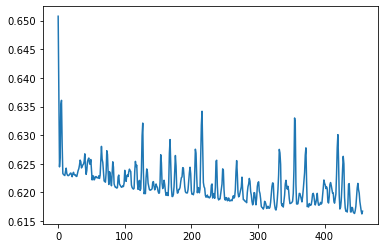

In [10]:

plt.plot(np.asarray(val_loss_g_))
best_model_test_loss_g

array(0.5274386, dtype=float32)

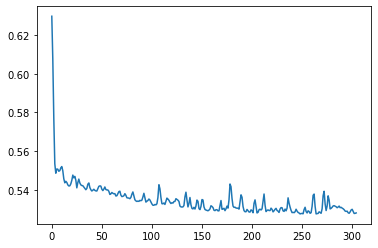

In [11]:

plt.plot(np.asarray(val_loss_q_))
best_model_test_loss_q